## Image-Sweep

### Dataset preperation

In [1]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import pandas as pd

import time
import PIL.Image as Image
from IPython.display import Image, display
import matplotlib.cm as cm
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Data Augmentation

In [2]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomFlip('horizontal_and_vertical'),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomZoom(0.1),
      #tf.keras.layers.RandomCrop(1024, 1024),
    ])

In [3]:
directory = "data/"

BATCH_SIZE = 32
IMG_SIZE = (192, 192)

train_dataset = tf.keras.utils.image_dataset_from_directory(directory,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "training")

validation_dataset = tf.keras.utils.image_dataset_from_directory(directory,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "validation")

Found 824 files belonging to 2 classes.
Using 660 files for training.
Found 824 files belonging to 2 classes.
Using 164 files for validation.


2024-05-28 16:34:00.138991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


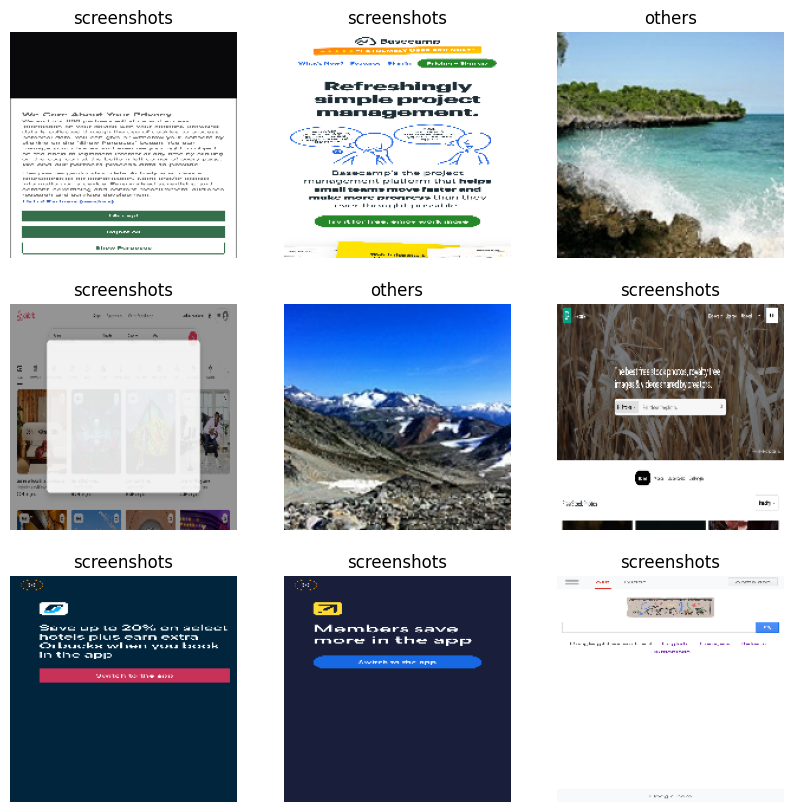

In [4]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 4
Number of test batches: 1


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2024-05-28 16:34:24.916342: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-28 16:34:24.916405: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(32, 6, 6, 1280)


In [16]:
base_model.trainable = False

In [17]:
#base_model.summary()

In [18]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_192            │ (None, 6, 6, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.3369 - loss: 1.1991
initial loss: 1.18
initial accuracy: 0.35


In [22]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
model.save('model2.keras')

Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.3636 - loss: 1.2091 - val_accuracy: 0.3800 - val_loss: 0.8858
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.3493 - loss: 1.0137 - val_accuracy: 0.4200 - val_loss: 0.7432
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.4563 - loss: 0.8846 - val_accuracy: 0.5500 - val_loss: 0.6779
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.4863 - loss: 0.7959 - val_accuracy: 0.6300 - val_loss: 0.6323
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.5268 - loss: 0.7815 - val_accuracy: 0.6500 - val_loss: 0.5937


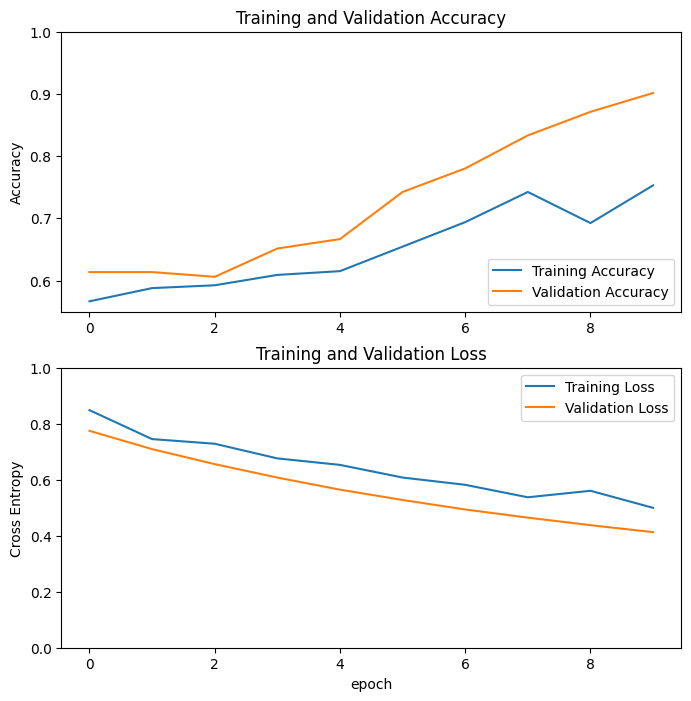

In [156]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [157]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8438 - loss: 0.4618
Test accuracy : 0.84375


Predictions:
 [0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0]
Labels:
 [0 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0]


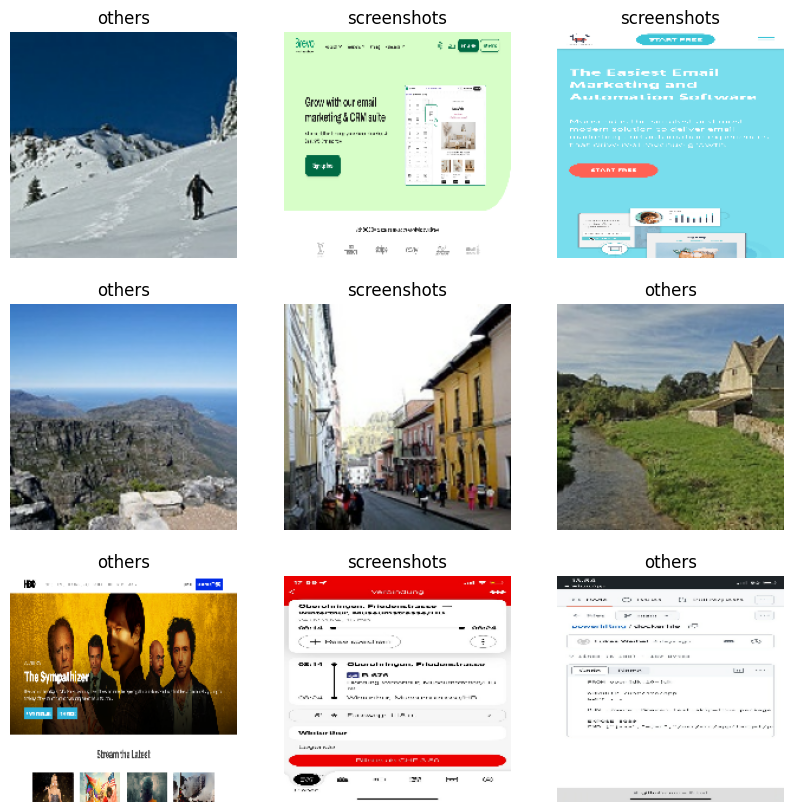

In [158]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# Get model predictions. Note: Do not flatten here.
predictions = model.predict_on_batch(image_batch)

# Convert predictions to class indices based on the threshold
predicted_class_index = (predictions > 0.5).astype(int)

# Print the predictions and labels horizontally
print('Predictions:\n', predicted_class_index.flatten())
print('Labels:\n', label_batch.flatten())

# Optionally, visualize predictions with images
batch_size = image_batch.shape[0]  # Get the actual batch size
num_to_plot = min(batch_size, 9)  # Plot up to 9 images or fewer if batch_size is less than 9
plt.figure(figsize=(10, 10))
for i in range(num_to_plot):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predicted_class_index[i][0]])  # Ensure correct indexing in class_names
    plt.axis("off")
plt.show()

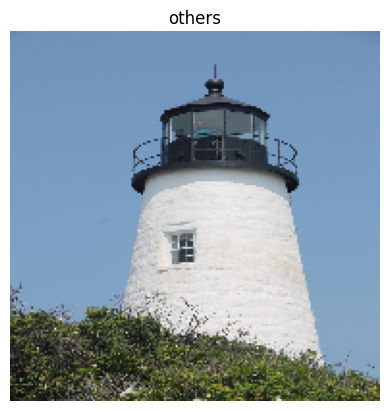

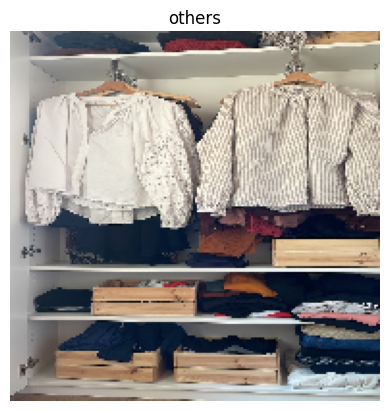

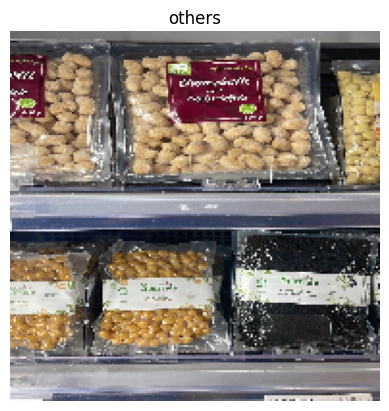

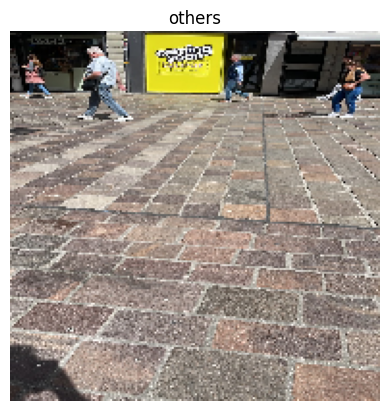

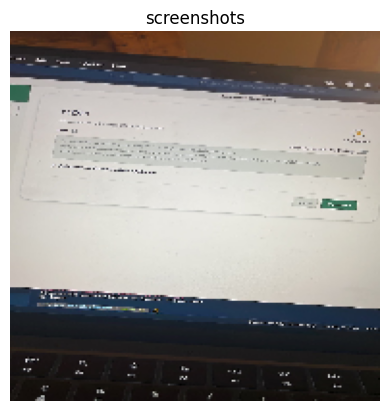

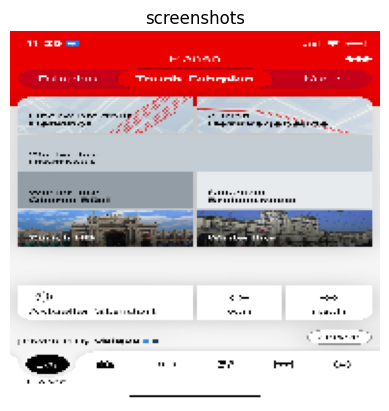

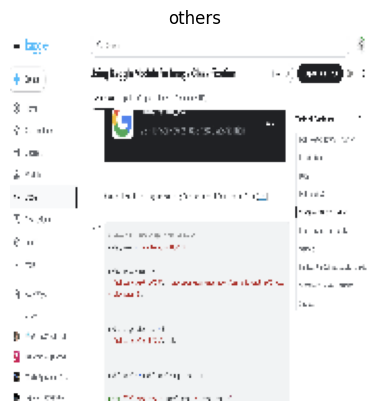

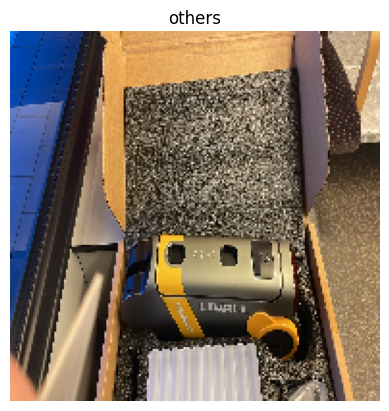

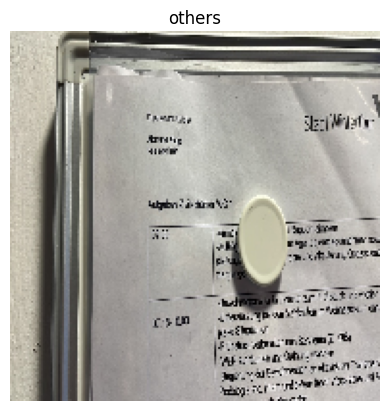

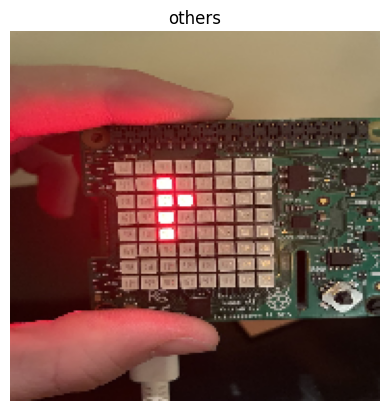

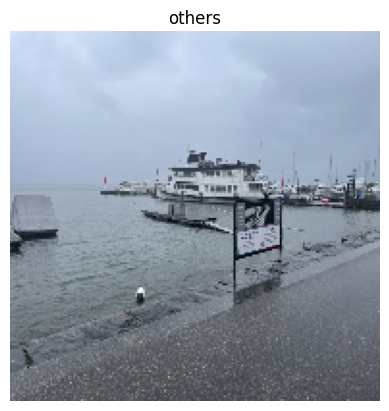

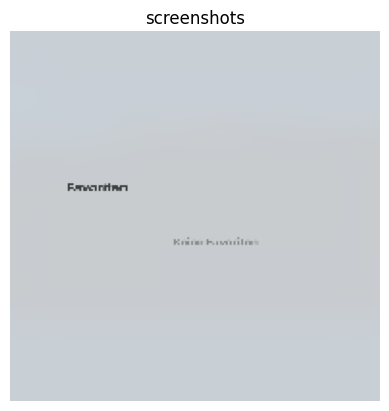

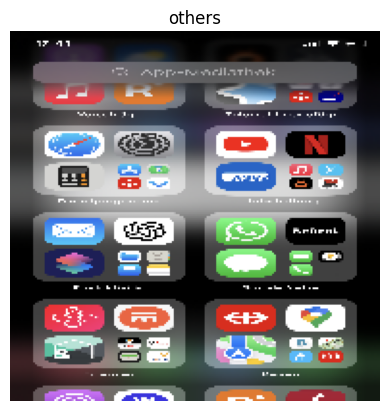

In [159]:
# Directory containing the images
directory = "examples/"

# List to store images and predictions
images = []
predictions = []
true_predictions = []

# Loop through all files in the directory
current_index = -1
for filename in os.listdir(directory):
    img_path = os.path.join(directory, filename)
    if filename.lower().endswith((".png", ".jpg", ".jpeg")):  # Check file extension
        # Load and preprocess the image
        img = tf.keras.utils.load_img(img_path, target_size=(192, 192))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Add the batch dimension

        # Get model predictions
        prediction = model.predict_on_batch(img_array)

        # Convert prediction to class index
        predicted_class_index = (prediction > 0.5).astype(int)
        predicted_class = class_names[predicted_class_index[0][0]]  # Correct class name fetching

        # Store image and prediction
        images.append(img)
        predictions.append(predicted_class)
        true_predictions.append(None)  # Initialize with None
        
        current_index += 1

        # Display image and prediction
        plt.imshow(img)
        plt.title(predicted_class)
        plt.axis("off")
        plt.show()
        
        buttons = []

        correct_button = widgets.Button(description="correct", button_style='info')
        not_correct_button = widgets.Button(description="wrong", button_style='info')

        # Set the tooltip to store the current index
        correct_button.tooltip = str(current_index)
        not_correct_button.tooltip = str(current_index)

        buttons.append(correct_button)
        buttons.append(not_correct_button)

        # Define a function to handle button clicks for this image
        def on_button_clicked(b, correct_button=correct_button, not_correct_button=not_correct_button):
            index = int(b.tooltip)

            if b.description == "correct":
                true_predictions[index] = predictions[index]
                correct_button.button_style = 'success'
                not_correct_button.button_style = 'info'
            else:
                for i, pred in enumerate(predictions):
                    if i != index:
                        true_predictions[index] = pred
                        break
                not_correct_button.button_style = 'danger'
                correct_button.button_style = 'info'

        correct_button.on_click(lambda b, correct_button=correct_button, not_correct_button=not_correct_button: on_button_clicked(b, correct_button, not_correct_button))
        not_correct_button.on_click(lambda b, correct_button=correct_button, not_correct_button=not_correct_button: on_button_clicked(b, correct_button, not_correct_button))

        display(widgets.HBox(buttons))

        
true_predictions = predictions.copy()


In [160]:
print(images)
print(true_predictions)

[<PIL.Image.Image image mode=RGB size=192x192 at 0x2970D6290>, <PIL.Image.Image image mode=RGB size=192x192 at 0x293B78650>, <PIL.Image.Image image mode=RGB size=192x192 at 0x28E037D90>, <PIL.Image.Image image mode=RGB size=192x192 at 0x2925662D0>, <PIL.Image.Image image mode=RGB size=192x192 at 0x293B6FD50>, <PIL.Image.Image image mode=RGB size=192x192 at 0x2EA88A890>, <PIL.Image.Image image mode=RGB size=192x192 at 0x28E268350>, <PIL.Image.Image image mode=RGB size=192x192 at 0x28DE2FC50>, <PIL.Image.Image image mode=RGB size=192x192 at 0x28E2A6390>, <PIL.Image.Image image mode=RGB size=192x192 at 0x2939461D0>, <PIL.Image.Image image mode=RGB size=192x192 at 0x290EB6250>, <PIL.Image.Image image mode=RGB size=192x192 at 0x2A1103DD0>, <PIL.Image.Image image mode=RGB size=192x192 at 0x293768B90>]
['others', 'others', 'others', 'others', 'screenshots', 'screenshots', 'others', 'others', 'others', 'others', 'others', 'screenshots', 'others']


In [ ]:
# Fine-tune the model using the corrected predictions
# Create a dataset from the images and the corrected labels
train_images = []
train_labels = []

for i, img in enumerate(images):
    if true_predictions[i] is not None:
        train_images.append(tf.keras.utils.img_to_array(img))
        train_labels.append(class_names.index(true_predictions[i]))

train_images = tf.convert_to_tensor(train_images)
train_labels = tf.convert_to_tensor(train_labels)

# Ensure the model's output layer matches the number of classes
if model.layers[-1].units != len(class_names):
    model.pop()
    model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

# Compile the existing model with the correct number of classes
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with the corrected data
model.fit(train_images, train_labels, epochs=5, validation_split=0.2)

AttributeError: 'Functional' object has no attribute 'pop'